In [37]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
N_alpha = 6
N_params = 2
N_rollouts = 50
N_iter = 200
alpha_vals = np.linspace(0.5,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [MultiArmedBandit(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = np.ones(N_params, dtype='float')/N_params

We perform a rollout on every MDP with every $\alpha$ value

In [15]:
for i, alpha in enumerate(alpha_vals):
    for j, mdp in enumerate(mdps):
        agent = RiskAverseMCTS(mdps, belief, max_depth=10, 
                               alpha=alpha, max_r=1., n_iter=N_iter )
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 0.24 	var_r: 0.0004
 a = 0.6 	avg_r: 0.4 	var_r: 0.0676
 a = 0.7 	avg_r: 0.45 	var_r: 0.0729
 a = 0.8 	avg_r: 0.47 	var_r: 0.2209
 a = 0.9 	avg_r: 0.51 	var_r: 0.2401
 a = 1.0 	avg_r: 0.51 	var_r: 0.2401


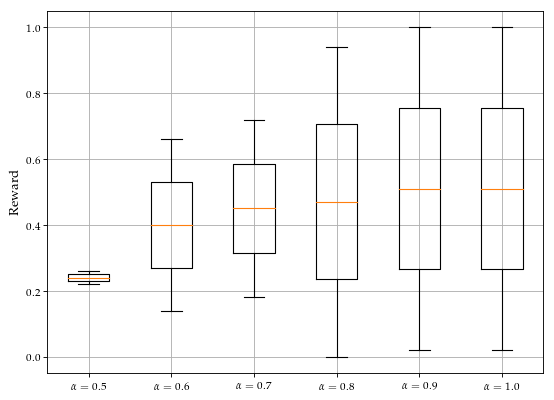

In [19]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
plt.boxplot(np.mean(rewards[:,:,:], axis=2).T, labels=labels)
#plt.title("Distribution of Average Total Cost over Model Uncertainty", fontsize=18)
plt.ylabel("Reward", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('bandit_spreads.pdf')
plt.grid(True)
plt.show()

# Convergence plots

In [38]:
belief_curves = []
agent_value_curves = []
adv_value_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseMCTS(mdps, belief, max_depth=5, 
                               alpha=alpha, max_r=1.5, n_iter=200 )
    s0 = mdps[0].reset()
    agent.MCTS(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Wha[(s0,a)] for a in mdps[0].action_space(s0)] )

In [20]:
(1 - np.array(final_q_vals)).T

array([[ 0.80219098,  0.80740235,  0.80046381,  0.79881405,  0.79943282,
         0.80349345],
       [ 0.81220791,  0.76852881,  0.72987974,  0.68692636,  0.65434075,
         0.64454443],
       [ 0.84604151,  0.77033052,  0.71489912,  0.65972321,  0.60416737,
         0.58834951],
       [ 0.93640477,  0.85193015,  0.74247294,  0.63777822,  0.56452046,
         0.50613764]])

In [21]:
np.array(final_n_vals).T

array([[ 21945.05366407,   4205.52114975,   1692.81686586,    654.42410605,
           348.35705483,    229.        ],
       [ 13113.36700628,  17834.49834927,  10284.7924899 ,   3820.3726238 ,
          1745.92243015,    889.        ],
       [  4083.06647125,  16300.27793779,  21562.10727   ,   8880.09510763,
          5363.13521147,   2060.        ],
       [   858.5128584 ,   1659.7025632 ,   6460.28337424,  26645.10816253,
         32542.58530355,  36822.        ]])

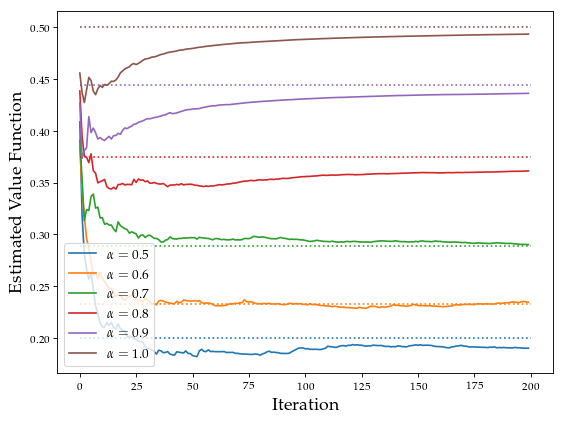

In [42]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
true_vals = 1-np.array([0.8,0.767,0.711,0.625,0.556,0.500])
for i,a in enumerate(alpha_vals):
    h, = plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
    plt.plot([0,N_iter],[true_vals[i], true_vals[i]], linestyle=':', color=h.get_color())
#plt.title("Best Q Value", fontsize=18)
plt.ylabel("Estimated Value Function", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.savefig("bandit_value_convergence")
plt.show()

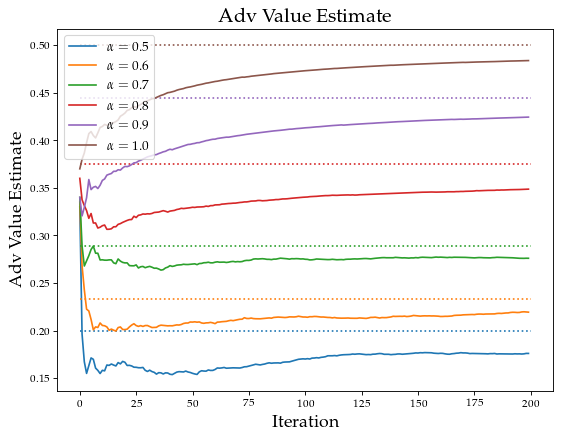

In [40]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    h, = plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
    plt.plot([0,N_iter],[true_vals[i], true_vals[i]], linestyle=':', color=h.get_color())
#plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [217]:
belief_curves = np.array(belief_curves)

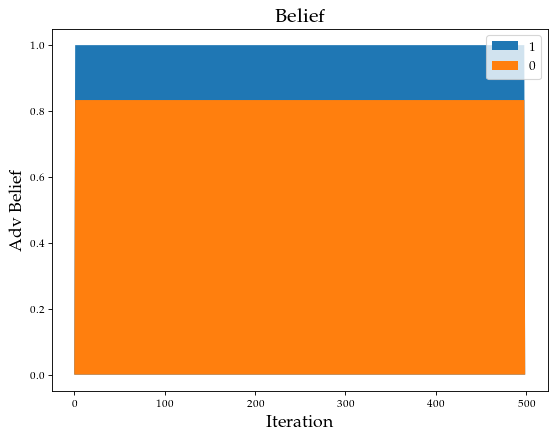

In [314]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
cum_belief_curves[:,0,:] = 0
cum_belief_curves[:,-1,:] = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(cum_belief_curves[1,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()